# Basic: Step scan with scaler and motor

From *APS Python Training for Bluesky Data Acquisition*.

**Objective**

Step scan of scaler and motor with table and plot.

In this lesson, we'll show how to use the tools provided with Bluesky to show the data as it is acquired using both a table representation and a graphical view, as well. These capabilities are provided by using callbacks. In lessons 1 and 2, we wrote our own simple callback to view the documents that come from the RunEngine during execution of a plan. Quickly, the data became too complex for simple viewing.

The *LiveTable* and *LivePlot* callbacks provide a table and graphical view of the data from the plan. We'll get to those first. Later, we'll show the *BestEffortCallback*, which combines both those callbacks plus a little more. For routine work, we'll want to use *BestEffortCallback* all the time. We'll show how to make that happen so we *set it and forget about it*.

-------

**note**:  This tutorial expects to find an EPICS IOC on the local network configured as a synApps [`xxx`](https://github.com/epics-modules/xxx) IOC with prefix `gp:`.  A docker container is available to provide this IOC.  See this URL for instructions:  https://github.com/prjemian/epics-docker/tree/main/v1.1/n5_custom_synApps/README.md

Starting with the configuration from the basic scaler and motor notebooks, we first group the `import`s together as is common Python practice:

In [1]:
from ophyd import EpicsMotor
from ophyd.scaler import ScalerCH
from bluesky import RunEngine
import bluesky.plans as bp

Next, make a RunEngine (for scanning) and connect our motor and scaler

In [2]:
RE = RunEngine({})

P = "gp:"
m1 = EpicsMotor(f"{P}m1", name="m1")
scaler = ScalerCH(f"{P}scaler1", name="scaler")

Reconfigure the scaler for channel names, set the counting time to 0.5 s, and read the scaler values.

In [3]:
scaler.channels.chan01.chname.put("clock")
scaler.channels.chan02.chname.put("I0")
scaler.channels.chan03.chname.put("scint")

scaler.preset_time.put(0.4)

scaler.select_channels()
scaler.read()

OrderedDict([('clock', {'value': 5000000.0, 'timestamp': 1627337978.650808}),
             ('I0', {'value': 1.0, 'timestamp': 1627337978.650808}),
             ('scint', {'value': 3.0, 'timestamp': 1627337978.650808}),
             ('roi1', {'value': 0.0, 'timestamp': 1627337978.650808}),
             ('roi2', {'value': 0.0, 'timestamp': 1627337978.650808}),
             ('scaler_time', {'value': 0.5, 'timestamp': 1627337978.650808})])

## Showing the data

In lessons 1 and 2, we wrote a *callback* routine that printed information as the scan prpogressed (that is, we *printed select content from the stream of documents emitted by the RunEngine while executing a plan*).  But our callback was simple and we found there is a lot of content in the documents from the RunEngine.

The [simplest example of a Bluesky callback](http://nsls-ii.github.io/bluesky/callbacks.html#simplest-working-example) is the `print` function.  We want a callback function that understands our data and uses reasonable assumptions to show that data as it is being acquired.

One method to display our data is in a [table](http://nsls-ii.github.io/bluesky/callbacks.html#livetable) that updates as the scan progresses.  We'll import the `LiveTable` callback from the Bluesky library:

In [4]:
from bluesky.callbacks import LiveTable

`LiveTable()` shows acquired data as a plan is executed.  The argument is the list of detectors to show in the table.  First, we'll count the scaler 5 times.

In [5]:
RE(bp.count([scaler], 5), LiveTable([scaler]))



+-----------+------------+------------+------------+------------+------------+-------------+------------+
|   seq_num |       time |         I0 |      clock |       roi1 |       roi2 | scaler_time |      scint |
+-----------+------------+------------+------------+------------+------------+-------------+------------+
|         1 | 17:21:27.3 |          1 |    5000000 |          0 |          0 |       0.500 |          2 |
|         2 | 17:21:27.9 |          1 |    5000000 |          0 |          0 |       0.500 |          2 |
|         3 | 17:21:28.4 |          1 |    5000000 |          0 |          0 |       0.500 |          1 |
|         4 | 17:21:28.9 |          1 |    5000000 |          0 |          0 |       0.500 |          1 |
|         5 | 17:21:29.4 |          2 |    5000000 |          0 |          0 |       0.500 |          3 |
+-----------+------------+------------+------------+------------+------------+-------------+------------+
generator count ['054e856f'] (scan num: 1)



('054e856f-b40b-4888-888a-828ba9e1822c',)

You see columns for the data collection sequence number, the time of collection, and each of the *named* scaler channels.  At the end, the short form for the scan's `uid` is shown as well as `scan num` which is a more convenient reference to the scan.  The user has control to set or reset `scan num` so do not rely on that number to be unique.

Next, we'll scan with motor and scaler, as we did in the [basic_motor](basic_motor.ipynb) lesson, displaying the acquired data in a `LiveTable`.

In [6]:
RE(bp.scan([scaler], m1, 1, 5, 5), LiveTable([m1, scaler]))



+-----------+------------+------------+------------------+------------+------------+------------+------------+-------------+------------+
|   seq_num |       time |         m1 | m1_user_setpoint |         I0 |      clock |       roi1 |       roi2 | scaler_time |      scint |
+-----------+------------+------------+------------------+------------+------------+------------+------------+-------------+------------+
|         1 | 17:21:34.5 |    1.00000 |          1.00000 |          3 |    5000000 |          0 |          0 |       0.500 |          1 |
|         2 | 17:21:36.3 |    2.00000 |          2.00000 |          3 |    5000000 |          0 |          0 |       0.500 |          2 |
|         3 | 17:21:38.2 |    3.00000 |          3.00000 |          2 |    5000000 |          0 |          0 |       0.500 |          2 |
|         4 | 17:21:40.1 |    4.00000 |          4.00000 |          1 |    5000000 |          0 |          0 |       0.500 |          2 |
|         5 | 17:21:42.0 |    5.

('b2a3ab4c-3abd-44d4-ae4e-2d826ce37bb5',)

In addition to the data columns from `count` above, the motor position (both where the motor reported as its position and where the motor was told to go, respectively) are shown.

---------
There is a callback routine that will plot the data as it is acquired.  When starting graphics, it is necessary to first initialize the graphics manager of the display.  The setup is specific to the graphics manager.  For command line or python program use, see http://nsls-ii.github.io/bluesky/callbacks.html#aside-making-plots-update-live.

For jupyter notebooks:

In [7]:
%matplotlib inline

We'll import the `LivePlot` callback from the Bluesky library:

In [8]:
from bluesky.callbacks import LivePlot

Count the scaler 5 times.  We'll just plot the `scint` signal.

('75b38b8c-8c96-40c6-b998-566fe12bc21b',)

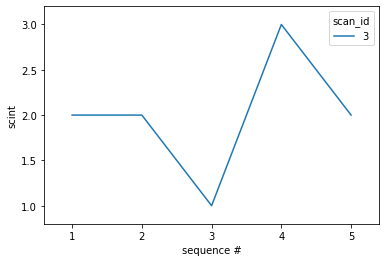

In [9]:
RE(bp.count([scaler],num=5), LivePlot("scint"))

To scan, we need to tell `LivePlot` to plot `scint` *vs.* the motor:

('38412f35-1cf8-4974-9796-7f0372bb6d69',)

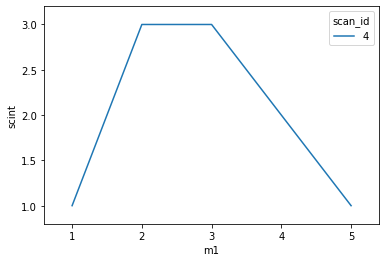

In [10]:
RE(bp.scan([scaler], m1, 1, 5, 5), LivePlot("scint", "m1"))

------------------
Both the table and the plot are very useful diagnostics for routine use.  They have been combined in the [*Best-Efforts Callback*](http://nsls-ii.github.io/bluesky/callbacks.html#best-effort-callback) which provides best-effort plots and visualization for any plan.  It uses [user-configurable information](http://nsls-ii.github.io/bluesky/callbacks.html#hints) that is part of every ophyd device to make reasonable assumptions about what information is appropriate to display in the context of the current plan.

We'll import the `BestEffortCallback` callback from the Bluesky library:

In [11]:
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

Count the scaler 5 times:



Transient Scan ID: 5     Time: 2021-07-26 17:21:58
Persistent Unique Scan ID: '4fec1288-eb0e-47d5-8a17-d584aee9a197'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |      clock |         I0 |      scint |       roi1 |       roi2 |
+-----------+------------+------------+------------+------------+------------+------------+
|         1 | 17:21:59.0 |    5000000 |          3 |          1 |          0 |          0 |
|         2 | 17:22:00.0 |    5000000 |          1 |          3 |          0 |          0 |
|         3 | 17:22:01.0 |    5000000 |          2 |          2 |          0 |          0 |
|         4 | 17:22:01.9 |    5000000 |          1 |          2 |          0 |          0 |
|         5 | 17:22:02.9 |    5000000 |          2 |          3 |          0 |          0 |
+-----------+------------+------------+------------+------------+------------+------------+
generator count ['4fec1288'] (s

('4fec1288-eb0e-47d5-8a17-d584aee9a197',)

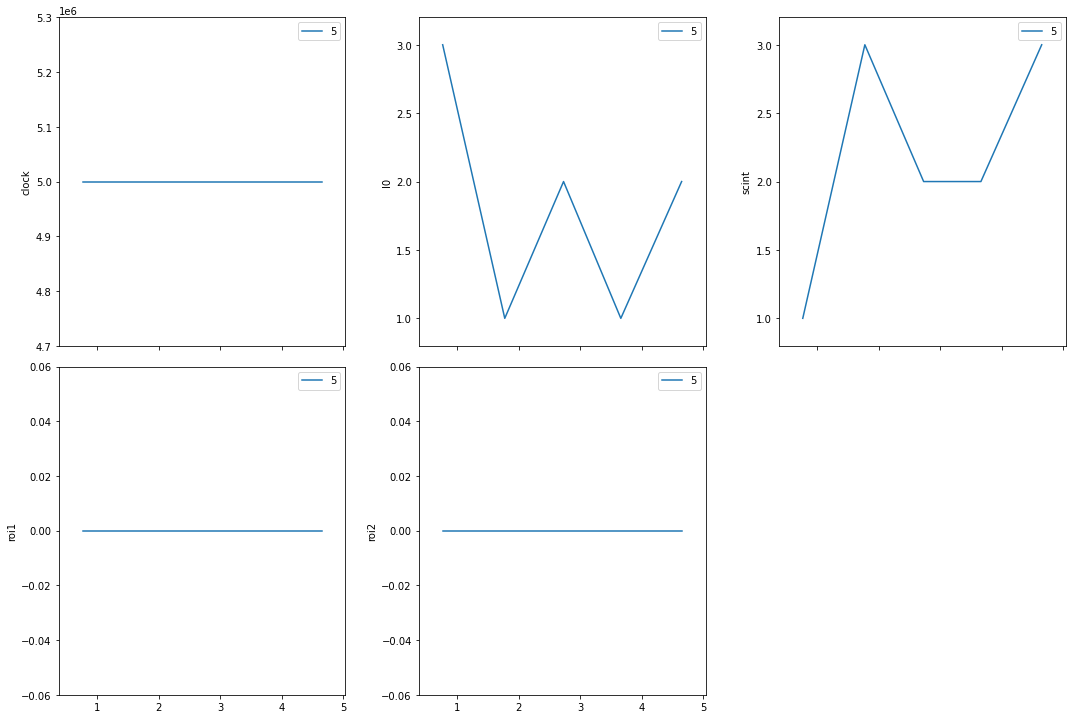

In [12]:
RE(bp.count([scaler], num=5), bec)

You might see both the `LiveTable` and the `LivePlot` output tangled up here in the jupyter notebook.  Each is created on demand and then updated as the plan progresses.  When executing in a command line environment, the `LivePlot` is shown in a separate window.

Repeat the same scan, noting that we do not need to inform the callback what to display:



Transient Scan ID: 6     Time: 2021-07-26 17:22:04
Persistent Unique Scan ID: '09c823a1-1e6c-448a-bdce-5018a9b02e8b'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |         m1 |      clock |         I0 |      scint |       roi1 |       roi2 |
+-----------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 17:22:09.2 |    1.00000 |    5000000 |          1 |          2 |          0 |          0 |
|         2 | 17:22:11.4 |    2.00000 |    5000000 |          3 |          2 |          0 |          0 |
|         3 | 17:22:13.7 |    3.00000 |    5000000 |          2 |          3 |          0 |          0 |
|         4 | 17:22:15.9 |    4.00000 |    5000000 |          2 |          1 |          0 |          0 |
|         5 | 17:22:18.2 |    5.00000 |    5000000 |          1 |          3 |          0 |          0 |
+-----------+------

/home/prjemian/.local/lib/python3.8/site-packages/bluesky/callbacks/fitting.py:165: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


('09c823a1-1e6c-448a-bdce-5018a9b02e8b',)

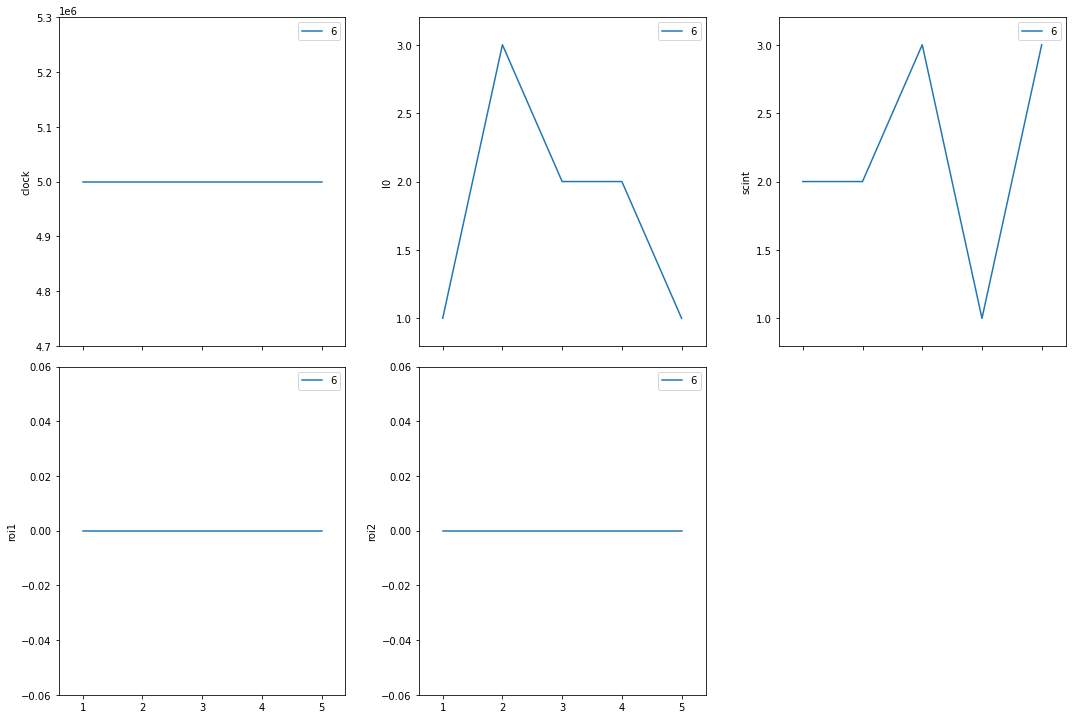

In [13]:
RE(bp.scan([scaler], m1, 1, 5, 5), bec)

Because this is such a useful tool, we want to make this callback happen all the time.  The RunEngine manages a list of such callbacks.  We'll make a new RunEngine and *subscribe* the `BestEffortCallback` to it:

In [14]:
RE = RunEngine({})
RE.subscribe(bec)

0

Repeat the count of the scaler (without adding the callback in the command):

In jupyter notebook, we can see the `LiveTable` after our scan command.  To see the `LivePlot`, we have to look up a few cells, where the plots of scaler channels *vs.* `m1` are shown, our latest data identified by `scan num` in the legend.RE(bp.count([scaler], num=5))



Transient Scan ID: 1     Time: 2021-07-26 17:22:19
Persistent Unique Scan ID: '4e6f577d-572b-4dc1-8621-6e4e1e9007c1'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |      clock |         I0 |      scint |       roi1 |       roi2 |
+-----------+------------+------------+------------+------------+------------+------------+
|         1 | 17:22:20.1 |    5000000 |          2 |          2 |          0 |          0 |
|         2 | 17:22:21.0 |    5000000 |          3 |          2 |          0 |          0 |
|         3 | 17:22:22.0 |    5000000 |          2 |          2 |          0 |          0 |
|         4 | 17:22:22.9 |    5000000 |          3 |          2 |          0 |          0 |
|         5 | 17:22:24.0 |    5000000 |          3 |          3 |          0 |          0 |
+-----------+------------+------------+------------+------------+------------+------------+
generator count ['4e6f577d'] (s

('4e6f577d-572b-4dc1-8621-6e4e1e9007c1',)

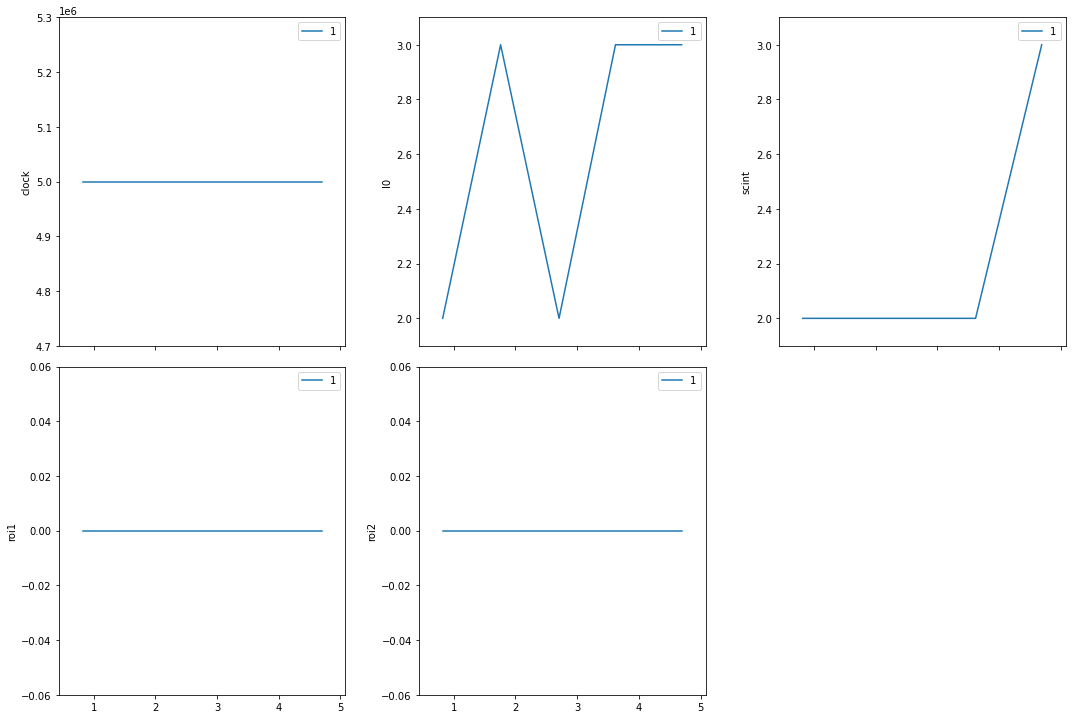

In [15]:
RE(bp.count([scaler], num=5))

In jupyter notebook, we can see the `LiveTable` after our count command.  To see the `LivePlot`, we have to look up a few cells, where the plots of scaler channels *vs.* *time* are shown, our latest data identified by `scan num` in the legend.

Then, repeat the scan (again, without adding the callback in the command):



Transient Scan ID: 2     Time: 2021-07-26 17:22:25
Persistent Unique Scan ID: '37c42493-6534-4839-8041-d832b8bad9b6'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+------------+
|   seq_num |       time |         m1 |      clock |         I0 |      scint |       roi1 |       roi2 |
+-----------+------------+------------+------------+------------+------------+------------+------------+
|         1 | 17:22:30.2 |    1.00000 |    5000000 |          2 |          2 |          0 |          0 |
|         2 | 17:22:32.5 |    2.00000 |    5000000 |          3 |          2 |          0 |          0 |
|         3 | 17:22:34.7 |    3.00000 |    5000000 |          2 |          1 |          0 |          0 |
|         4 | 17:22:36.9 |    4.00000 |    5000000 |          2 |          3 |          0 |          0 |
|         5 | 17:22:39.2 |    5.00000 |    5000000 |          3 |          1 |          0 |          0 |
+-----------+------

('37c42493-6534-4839-8041-d832b8bad9b6',)

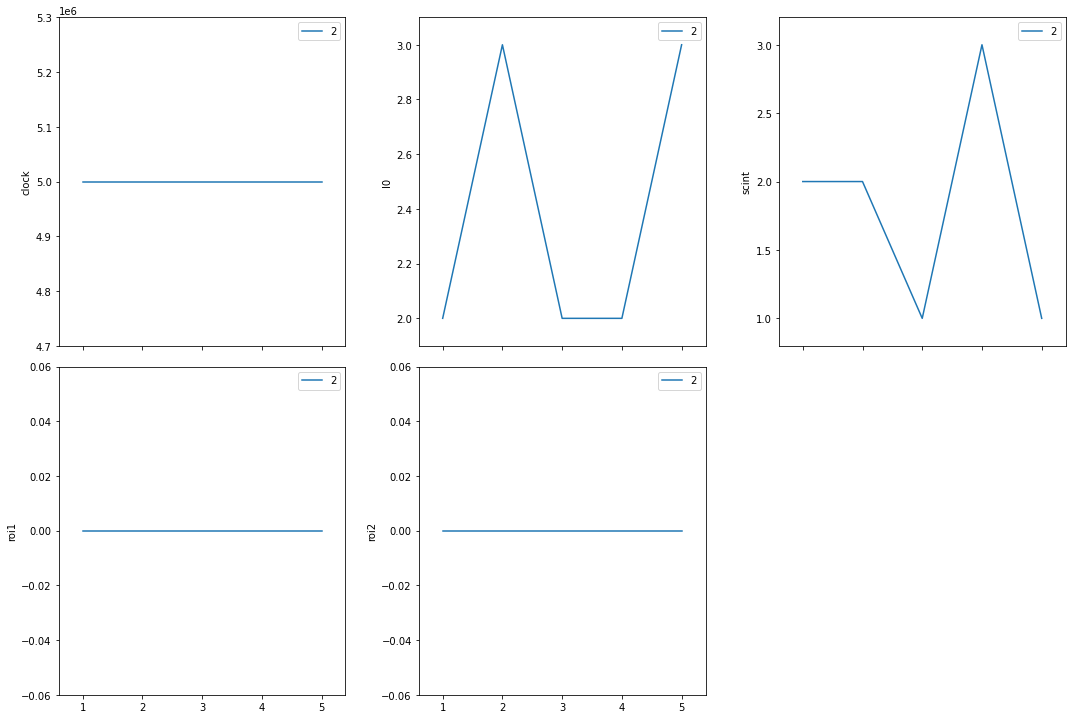

In [16]:
RE(bp.scan([scaler], m1, 1, 5, 5))

In jupyter notebook, we can see the `LiveTable` after our scan command.  Notice that the number of columns displayed is less than when we called `LiveTable` ourselves.  To see the `LivePlot`, we have to look up a few cells, where the plots of scaler channels *vs.* `m1` are shown, our latest data identified by `scan num` in the legend.

# Summary

We'll show this code as a python program:

```
#!/usr/bin/env python

"""Basic: Step scan with scaler and motor"""

from ophyd import EpicsMotor
from ophyd.scaler import ScalerCH
from bluesky import RunEngine
import bluesky.plans as bp
from bluesky.callbacks import LiveTable
from bluesky.callbacks import LivePlot
from bluesky.callbacks.best_effort import BestEffortCallback
from apstools.devices import use_EPICS_scaler_channels


%matplotlib inline


RE = RunEngine({})

P = "gp:"
m1 = EpicsMotor(f"{P}m1", name="m1")
scaler = ScalerCH(f"{P}scaler1", name="scaler")
m1.wait_for_connection()
scaler.wait_for_connection()
scaler.preset_time.put(0.4)
scaler.select_channels()
print(scaler.read())

RE(bp.count([scaler], num=5), LiveTable([scaler]))
RE(bp.scan([scaler], m1, 1, 5, 5), LiveTable([m1, scaler]))

RE(bp.count([scaler], num=5), LivePlot("scint"))
RE(bp.scan([scaler], m1, 1, 5, 5), LivePlot("scint", "m1"))

bec =  BestEffortCallback()
RE(bp.count([scaler], num=5), bec)
RE(bp.scan([scaler], m1, 1, 5, 5), bec)

RE = RunEngine({})
RE.subscribe(bec)

RE(bp.count([scaler], num=5))
RE(bp.scan([scaler], m1, 1, 5, 5))
```